# Prepare data

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt
from sklearn import  metrics
 
# custom utils and random forest scripts
from Utils import ETL_emb, count_test_period

# dummy variable list            
from holidayList import hol_list

LOGNUMBER = 'e2e_seq2seq'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL_emb()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

forecast_ids = list(test_lengths.keys())
site_ids = list(df_sub.SiteId.unique())

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

def preprocess_seq2seq(df_train,df_sub):
    # add train / test marker
    df_train['is_train'] = 1
    df_sub['is_train'] = 0

    # merge dataframes together
    data_df = df_train.append(df_sub)
    del df_train,df_sub
    
    # sort dataframe by site_id and timestamp 
    # so that we could easily use ar features 
    # and do indexing
    data_df['Timestamp'] = pd.to_datetime(data_df['Timestamp'] )
    data_df = data_df.sort_values(by = ['SiteId','Timestamp'])
    
    # replace non-existent temperature with base temperature
    data_df.loc[(data_df.Temperature == -1),'Temperature'] = data_df.loc[(data_df.Temperature == -1),'BaseTemperature']    
    
    
    # produce future features for temperature
    """
    print('Producing shifted future temperature features ...')
    with tqdm.tqdm(total=len(site_ids)) as pbar:
        for site_id in site_ids:
            data_df.loc[data_df.SiteId == site_id, 'FT1'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-1)
            data_df.loc[data_df.SiteId == site_id, 'FT5'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-5)
            data_df.loc[data_df.SiteId == site_id, 'FT10'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-10)
            data_df.loc[data_df.SiteId == site_id, 'FT50'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-50)

            data_df.loc[data_df.SiteId == site_id, 'FT1'] = data_df.loc[data_df.SiteId == site_id, 'FT1'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT5'] = data_df.loc[data_df.SiteId == site_id, 'FT5'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT10'] = data_df.loc[data_df.SiteId == site_id, 'FT10'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT50'] = data_df.loc[data_df.SiteId == site_id, 'FT50'].fillna(method='ffill')

            pbar.update(1)
    """
    
    # remove very drastic outliers 
    print('Removing drastic outliers ... ')
    with tqdm.tqdm(total=len([1964, 1968, 1969, 4325, 5276, 5536])) as pbar:
        for forecast_id in [1964, 1968, 1969, 4325, 5276, 5536]:
            data_df.loc[(data_df.ForecastId == forecast_id)
                        &(data_df.Value>10**8), 'Value'] = np.nan

            data_df.loc[data_df.ForecastId == forecast_id, 'Value'] = data_df.loc[data_df.ForecastId == forecast_id, 'Value'].fillna(method='ffill')
            data_df.loc[data_df.ForecastId == forecast_id, 'Value'] = data_df.loc[data_df.ForecastId == forecast_id, 'Value'].fillna(method='bfill')

            pbar.update(1)
            
    return data_df

data_df = preprocess_seq2seq(df_train,df_sub)
# reset index to make sure we do not have double indexes and for easier indexing
data_df = data_df.reset_index()
del data_df['index']

# leave only the first holiday
data_df = data_df[(data_df['obs_id'].shift(+1) != data_df['obs_id'])]
data_df = data_df.reset_index()
del data_df['index']
# fill days wo holidays with -1
data_df['Holiday'] = data_df['Holiday'].fillna(value=-1)

Starting the ETL process
Time taken to complete the ETL process 178.52322030067444


 17%|█▋        | 1/6 [00:00<00:00,  6.24it/s]

Removing drastic outliers ... 


100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


In [2]:
# interpolation pipeline
# (1) find normal series
# (2) find series with all NaNs => mark as submit zeroes
# (3) use linear interpolation for series with < 0.2 NaNs
# (4) series with > 0.5 NaNs => submit averages
# (5) series with at least one test set worth of data immediately before test set => truncate train data
# (6) submit averages for the remaining series
# in the end we have
# (1) normal or interpolated series
# (2) submit zeroes
# (3) submit averages


data_df['is_null'] = 0
data_df.loc[pd.isnull(data_df.Value),'is_null'] = 1

# find normal time series
null_df = data_df[data_df.is_train == 1].groupby(['ForecastId'])['is_null'].sum()
count_df = data_df[data_df.is_train == 1].groupby(['ForecastId'])['is_null'].count()
stat_df = pd.DataFrame()
stat_df['null_count'] = null_df
stat_df['count'] = count_df
stat_df['percent_null'] = stat_df['null_count']/stat_df['count']
# stat_df[stat_df.percent_null>0].percent_null.plot(kind='hist')
normal_forecast_ids = list(stat_df[(stat_df.percent_null==0)].index.values)

# all non-normal series
# that have all the train dataset values equal to NAs
submit_zeroes = list(stat_df[(stat_df.percent_null==1)].index)
# that have the majority of values equal to NAs
submit_averages = list(stat_df[(stat_df.percent_null>0.5)
                               &(stat_df.percent_null<1)].index)
# use linear interpolation for values between 0 and 0.2
linear_interpolation = list(stat_df[(stat_df.percent_null>0)
                               &(stat_df.percent_null<0.2)].index)

data_df.loc[data_df.ForecastId.isin(linear_interpolation),'Value'] = data_df.loc[data_df.ForecastId.isin(linear_interpolation),'Value'].interpolate(method='linear')

try_truncating = list(stat_df[(stat_df.percent_null>0.2)
                               &(stat_df.percent_null<0.5)].index)

use_last_window = []

for forecast_id in try_truncating:
    test_len = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==0)].shape[0]
    
    last_window = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==1)].iloc[-test_len * 2 - 1:]
    
    non_blank_last_window = last_window[pd.notnull(last_window.Value)].shape[0] / last_window.shape[0]
    
    if (non_blank_last_window == 1):
        use_last_window.append(forecast_id)
    else:
        submit_averages.append(forecast_id)
        
# drop non-last values for these forecast_ids
for forecast_id in use_last_window:
    
    test_len = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==0)].shape[0]

    drop_index = data_df[data_df.ForecastId == forecast_id].index[:-test_len * 3 - 1]

    data_df.drop(index=drop_index,inplace=True,axis=0)         
    
train_forecast_ids = normal_forecast_ids + linear_interpolation + use_last_window    

# Try e2e models

In [4]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,MultiStepLR
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# custom classes
from SDataset import S2SDataset
from ELstm import E2ELSTM,WMSELoss,E2ELSTM_day

import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
import numpy as np
from math import sqrt

def train(train_loader,
          model,
          criterion,
          optimizer,
          epoch):
    losses = AverageMeter()
    # switch to train mode
    model.train()

    for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(train_loader):
        
        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
        X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),1).float()
        y_sequences = y_sequences.view(-1,y_sequences.size(2)).float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        
        x_temp_var = torch.autograd.Variable(X_sequences_temp)
        x_meta_var = torch.autograd.Variable(X_sequences_meta)
        x_ar_var = torch.autograd.Variable(X_sequences_ar)
        y_var = torch.autograd.Variable(y_sequences)
        
        # x_temp_var = torch.autograd.Variable(X_sequences_temp.cuda(async=True))
        # x_meta_var = torch.autograd.Variable(X_sequences_meta.cuda(async=True))
        # x_ar_var = torch.autograd.Variable(X_sequences_ar.cuda(async=True))
        # y_var = torch.autograd.Variable(y_sequences.cuda(async=True))

        # compute output
        output = model(x_temp_var,x_meta_var,x_ar_var)
        loss = criterion(output, y_var)

        # measure accuracy and record loss
        losses.update(loss.data[0], X_sequences_meta.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch, i, len(train_loader), loss=losses))        
           
    return losses.avg

def validate(val_loader, model, criterion):
    losses = AverageMeter()
    # switch to evaluate mode
    model.eval()

    for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(val_loader):
        
        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
        X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),1).float()
        y_sequences = y_sequences.view(-1,y_sequences.size(2)).float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(X_sequences_temp.cuda(async=True))
        x_meta_var = torch.autograd.Variable(X_sequences_meta.cuda(async=True))
        x_ar_var = torch.autograd.Variable(X_sequences_ar.cuda(async=True))
        y_var = torch.autograd.Variable(y_sequences.cuda(async=True))

        # compute output
        output = model(x_temp_var,x_meta_var,x_ar_var)
        loss = criterion(output, y_var)
        
        # measure accuracy and record loss
        losses.update(loss.data[0], X_sequences_meta.size(0))
        
        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   i, len(val_loader), loss=losses))      
            
    return losses.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [35]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def create_emb(cat_size = 7,
               max_emb_size = 50,
               output_size = 10,
               non_trainable=False):

    emb_size = min([(cat_size+2)//3, max_emb_size])    
    emb = nn.Embedding(output_size, emb_size)

    if non_trainable:
        for param in emb.parameters(): 
            param.requires_grad = False
    return emb, emb_size, output_size

class E2ELSTM_day(nn.Module):
    def __init__(self,
                 in_sequence_len = 192,
                 out_sequence_len = 192,
                 features_meta_total = 8,
                 features_ar_total = 1,
                 meta_hidden_layer_length = 192,
                 ar_hidden_layer_length = 192,
                 meta_hidden_layers = 2,
                 ar_hidden_layers = 1,
                 lstm_dropout = 0.5,
                 classifier_hidden_length = 192 * 2):
        
        super(E2ELSTM_day, self).__init__()

        self.meta_hidden_layer_length = meta_hidden_layer_length
        self.ar_hidden_layer_length = ar_hidden_layer_length
        self.meta_hidden_layers = meta_hidden_layers
        self.ar_hidden_layers = ar_hidden_layers      
        
        # create an embedding for each categorical feature
        self.hol_emb, emb_size, output_size = create_emb(cat_size = 73,
                                                       max_emb_size = 50,
                                                       output_size = 75)
        
        self.month_emb, emb_size, output_size = create_emb(cat_size = 12,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)  
        
        self.day_emb, emb_size, output_size = create_emb(cat_size = 31,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)
        
        self.dow_emb, emb_size, output_size = create_emb(cat_size = 7,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)          
   
        self.lstm_meta = nn.LSTM(features_meta_total,
                            meta_hidden_layer_length,
                            meta_hidden_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)
        
        self.lstm_ar = nn.LSTM(features_ar_total,
                            ar_hidden_layer_length,
                            ar_hidden_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)  


        self.classifier = nn.Sequential(
            nn.Linear(meta_hidden_layer_length + ar_hidden_layer_length, classifier_hidden_length),
            nn.BatchNorm2d(classifier_hidden_length),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(classifier_hidden_length, classifier_hidden_length),
            nn.BatchNorm2d(classifier_hidden_length),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(classifier_hidden_length, out_sequence_len),
        )
        
        """ 
        self.classifier = nn.Sequential(
            nn.Linear(meta_hidden_layer_length + ar_hidden_layer_length, classifier_hidden_length),
            nn.ReLU(True),
            nn.Linear(classifier_hidden_length, classifier_hidden_length),
            nn.ReLU(True),
            nn.Linear(classifier_hidden_length, out_sequence_len),
            nn.ReLU(True)
        ) 
        """


    
    def forward(self,
                x_temp,
                x_meta,
                x_ar):
        
        # embed and extract various features
        
        print(x_meta[:,:,0].size())
        print(x_meta[:,:,0].max())
        
        x_hol = self.hol_emb(x_meta[:,:,0])
        x_month = self.month_emb(x_meta[:,:,1])
        x_day = self.day_emb(x_meta[:,:,2])
        x_dow = self.dow_emb(x_meta[:,:,3])        

        x_meta = torch.cat([x_temp,x_hol,x_month,x_day,x_dow],dim=2)
        
        print(x_meta.size())
        
        # initial values for LSTMs
        h0_meta = Variable(torch.zeros(self.meta_hidden_layers, x_meta.size(0), self.meta_hidden_layer_length)) #.cuda()) 
        c0_meta = Variable(torch.zeros(self.meta_hidden_layers, x_meta.size(0), self.meta_hidden_layer_length)) #.cuda())
        
        h0_ar = Variable(torch.zeros(self.ar_hidden_layers, x_ar.size(0), self.ar_hidden_layer_length)) #.cuda()) 
        c0_ar = Variable(torch.zeros(self.ar_hidden_layers, x_ar.size(0), self.ar_hidden_layer_length)) #.cuda())         
        
        # Forward propagate LSTMs
        out_meta, _ = self.lstm_meta(x_meta, (h0_meta, c0_meta))  
        out_meta = out_meta[:, -1, :]
        
        out_ar, _ = self.lstm_ar(x_ar, (h0_ar, c0_ar))  
        out_ar = out_ar[:, -1, :]    
        
        out = torch.cat([out_meta,out_ar],dim=1)
       
        out = self.classifier(out)

        return out


In [34]:
# key params
lr = 1e-3
start_epoch = 0
epochs = 40
# 16 samples per batch
batch_size = 20
# lstm params
in_sequence_len = 30
out_sequence_len = 30
features_meta_total = 44
features_ar_total = 1
meta_hidden_layer_length = 30
ar_hidden_layer_length = 30
meta_hidden_layers = 2
ar_hidden_layers = 2
lstm_dropout = 0
# MLP model end params
# B x meta_hidden_layer_length || B x ar_hidden_layer_length => classifier_hidden_length => out_sequence_len
classifier_hidden_length = 256

In [25]:
torch.cuda.empty_cache()

RuntimeError: cuda runtime error (59) : device-side assert triggered at torch/csrc/cuda/Module.cpp:321

In [13]:
for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(train_loader):
    
    break

In [15]:
# transform data from Batch x Window x Etc into Batch x Etc format
X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
X_sequences_meta = X_sequences_meta[:,:,1:].long()

In [17]:
X_sequences_meta[:,:,5]


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     1     1  ...      1     1     1
    1     1     1  ...      1     1     1
    1     1     1  ...      1     1     1
[torch.LongTensor of size 320x60]

In [16]:
X_sequences_ar.size()

torch.Size([20, 16, 30])

In [11]:
train_dataset.tra

[3320,
 6152,
 6466,
 410,
 650,
 540,
 6151,
 6964,
 3707,
 6727,
 189,
 1905,
 3400,
 4294,
 3399,
 2358,
 3738,
 6462,
 5236,
 877,
 413,
 982,
 649,
 1390,
 6011,
 4394,
 5233,
 1534,
 6008,
 6972,
 2925,
 1319,
 4323,
 2977,
 4270,
 547,
 5229,
 5600,
 4325,
 1,
 3,
 2926,
 1529,
 6969,
 4293,
 4196,
 3310,
 3171,
 5239,
 6722,
 3318,
 983,
 6698,
 2264,
 543,
 4698,
 3901,
 879,
 412,
 6968,
 6009,
 190,
 648,
 4324,
 6965,
 5234,
 41,
 3899,
 878,
 4264,
 5255,
 5256,
 6467,
 2265,
 4266,
 6699,
 6967,
 2805,
 6005,
 2267,
 1512,
 5231,
 1318,
 3900,
 544,
 5599,
 5330,
 2980,
 1277,
 6256,
 1530,
 3314,
 5979,
 1391,
 4599,
 5235,
 4,
 3396,
 1649,
 4271,
 6729,
 6006,
 6725,
 1532,
 2979,
 880,
 407,
 3401,
 3311,
 3155,
 6471,
 6721,
 3235,
 408,
 414,
 2043,
 6470,
 4269,
 514,
 5598,
 2807,
 6468,
 4292,
 6254,
 6723,
 2266,
 1650,
 3398,
 1533,
 6007,
 6970,
 6469,
 5601,
 1977,
 1531,
 3234,
 542,
 1906,
 5254,
 6966,
 6460,
 6464,
 4267,
 1153,
 5238,
 6963,
 2,
 1535,
 

In [15]:
len(train_dataset.df.Holiday.unique())

72

In [23]:
trainval_X_sequences_meta.shape

(240, 120, 8)

NameError: name 'plt' is not defined

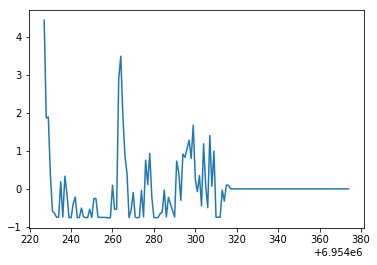

In [34]:
train_dataset.df[train_dataset.df.ForecastId == 6152].Value.plot()
plt.show()

In [36]:
idx = 0

for idx in train_dataset.train_f_ids:
    trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = train_dataset.__produce_idx_one__(forecast_id=idx)
    print(idx,trainval_y_sequences.shape,trainval_X_sequences_ar.shape)

3320 (300, 30) (300, 30)
6152 (30, 30) (30, 30)
6466 (300, 30) (300, 30)
410 (30, 30) (30, 30)
650 (300, 30) (300, 30)
540 (300, 30) (300, 30)
6151 (300, 30) (300, 30)
6964 (300, 30) (300, 30)
3707 (300, 30) (300, 30)
6727 (30, 30) (30, 30)
189 (300, 30) (300, 30)
1905 (300, 30) (300, 30)
3400 (300, 30) (300, 30)
4294 (300, 30) (300, 30)
3399 (30, 30) (30, 30)
2358 (300, 30) (300, 30)
3738 (30, 30) (30, 30)
6462 (300, 30) (300, 30)
5236 (30, 30) (30, 30)
877 (300, 30) (300, 30)
413 (30, 30) (30, 30)
982 (300, 30) (300, 30)
649 (30, 30) (30, 30)
1390 (300, 30) (300, 30)
6011 (30, 30) (30, 30)
4394 (30, 30) (30, 30)
5233 (300, 30) (300, 30)
1534 (300, 30) (300, 30)
6008 (300, 30) (300, 30)
6972 (300, 30) (300, 30)
2925 (300, 30) (300, 30)
1319 (30, 30) (30, 30)
4323 (300, 30) (300, 30)
2977 (300, 30) (300, 30)
4270 (300, 30) (300, 30)
547 (30, 30) (30, 30)
5229 (300, 30) (300, 30)
5600 (300, 30) (300, 30)
4325 (300, 30) (300, 30)
1 (300, 30) (300, 30)
3 (300, 30) (300, 30)
2926 (30, 30) 

In [22]:
import gc


gc.collect()

2677

In [36]:
# PyTorch training loop sugar

temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['year', 'month', 'day', 'hour', 'minute','dow']
target = ['Value']
predictors = temp_features + hol_emb_features + time_emb_features

model = E2ELSTM_day(in_sequence_len = in_sequence_len,
                 out_sequence_len = out_sequence_len,
                 features_meta_total = features_meta_total,
                 features_ar_total = features_ar_total,
                 meta_hidden_layer_length = meta_hidden_layer_length,
                 ar_hidden_layer_length = ar_hidden_layer_length,
                 meta_hidden_layers = meta_hidden_layers,
                 ar_hidden_layers = ar_hidden_layers,
                 lstm_dropout =lstm_dropout,
                 classifier_hidden_length = classifier_hidden_length)

# model.cuda()

train_dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '1_day',
                     in_sequence_len = 30,
                     out_sequence_len = 30,
                     target = 'Value',
                     mode = 'train',
                     split_mode = 'random',
                     predictors = predictors)

val_dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '1_day',
                     in_sequence_len = 30,
                     out_sequence_len = 30,
                     target = 'Value',
                     mode = 'val',
                     split_mode = 'random',
                     predictors = predictors)  

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,        
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,        
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=False)

criterion = nn.MSELoss().cuda()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr = lr)

scheduler = ReduceLROnPlateau(optimizer = optimizer,
                                          mode = 'min',
                                          factor = 0.1,
                                          patience = 4,
                                          verbose = True,
                                          threshold = 1e-3,
                                          min_lr = 1e-7
                                          )

Creating dataset object ...
Normalizing features ...
Creating dataset object ...
Normalizing features ...


In [37]:
with tqdm.tqdm(total=epochs) as pbar:
    for epoch in range(start_epoch, epochs):
        # train for one epoch
        train_loss = train(train_loader, model, criterion, optimizer, epoch)
        # evaluate on validation set
        val_loss = validate(val_loader, model, criterion)
        scheduler.step(val_loss)
        pbar.set_description('Epoch [{0}/{1}]'.format(str(epoch).zfill(3),str(epochs).zfill(3)), refresh=False)
        pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, refresh=False)
        pbar.update(1)

  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([320, 60])
Variable containing:
 66
[torch.LongTensor of size 1]

torch.Size([320, 60, 44])
Epoch: [0][0/9]	Loss 0.9687 (0.9687)	
torch.Size([320, 60])
Variable containing:
 68
[torch.LongTensor of size 1]

torch.Size([320, 60, 44])
torch.Size([320, 60])
Variable containing:
 71
[torch.LongTensor of size 1]

torch.Size([320, 60, 44])
torch.Size([320, 60])
Variable containing:
 71
[torch.LongTensor of size 1]

torch.Size([320, 60, 44])
torch.Size([320, 60])
Variable containing:
 68
[torch.LongTensor of size 1]

torch.Size([320, 60, 44])
torch.Size([320, 60])
Variable containing:
 63
[torch.LongTensor of size 1]

torch.Size([320, 60, 44])
torch.Size([320, 60])
Variable containing:
 71
[torch.LongTensor of size 1]

torch.Size([320, 60, 44])
torch.Size([320, 60])
Variable containing:
 68
[torch.LongTensor of size 1]

torch.Size([320, 60, 44])
torch.Size([128, 60])
Variable containing:
 51
[torch.LongTensor of size 1]

torch.Size([128, 60, 44])
torch.Size([320, 60])
Variable cont

TypeError: torch.index_select received an invalid combination of arguments - got ([32;1mtorch.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.cuda.LongTensor[0m), but expected (torch.FloatTensor source, int dim, torch.LongTensor index)

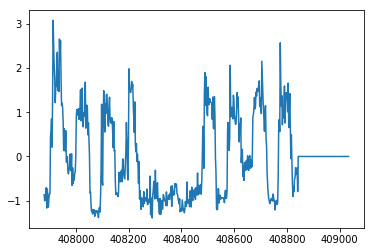

In [39]:
train_dataset.df[train_dataset.df.ForecastId == 359].Value.plot()

In [18]:
a = np.random.randint(1,size=(1,192))

In [ ]:
np.vstack([a] * 16)

In [22]:
list(range(0,16))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [21]:
np.vstack([a] * 16).shape

(16, 192)

In [15]:
x1.shape,x2.shape,y.shape

((64, 192), (64, 384, 8), (64, 192))

In [47]:
x2[idx,0].shape

(8,)

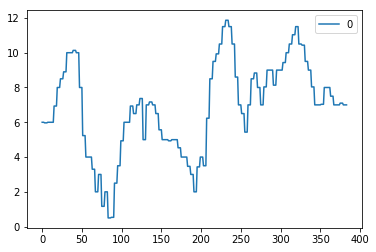

In [48]:
import matplotlib.pyplot as plt
idx = 10
plot_df = pd.DataFrame(list(x2[idx,:,0]))
plot_df.plot()
plt.show()

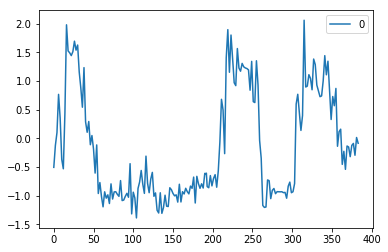

In [35]:
import matplotlib.pyplot as plt
idx = 38
plot_df = pd.DataFrame(list(x1[idx,:])+list(y[idx+10,:]))
plot_df.plot()
plt.show()

In [ ]:
def save_checkpoint(state, is_best, filename, best_filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_filename)

